In [3]:
import zipfile as zp
import pandas as pd
#from pypac import PACSession as Session #or use requests below if non-ONS
from requests import Session
from io import BytesIO
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Creating Summary Prescription Data for England

This code has been created to work with 2016, 2017 and 2018 data, earlier data may have format inconsistencies that need to be dealt with.

# Set File Location of Prescribing Data

These files are the "GP practice prescribing data - Presentation level" zip files that come from: https://data.gov.uk/dataset/176ae264-2484-4afe-a297-d51798eb8228/gp-practice-prescribing-data-presentation-level

In [1]:
# Path to zip files
path = r"[CHANGE THIS PATH]\England\\"

# Read in drug data

In [4]:
# Get drug data (NB some drugs duplicated for illnesses)
drug_data = pd.read_csv(path + r"..\drug_list.csv")

# Process Prescribing Data

This code iterates over the monthly prescribing data, ultimately producing an aggregate table.

Note, if you want to find prescribing for non-loneliness relatived diseases, all you need to do is provide a different set of drug_data and edit the code_loneliness function.

In [5]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x['BNF NAME'].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                  case=False, 
                                                  regex=True).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x['BNF NAME'].str.contains("|".join(drug_data['medication'].unique()),
                                                   case = False, 
                                                   regex = True).astype('int16')
    # Return dataframe multiplied by counts of items.
    return out.multiply(x['ITEMS'], axis=0)

In [6]:
# Make dictionary for aggregation
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols['ITEMS'] = 'sum'
agg_cols['loneliness'] = 'sum'
for key in ['Date','SHA','PCT','pcstrip','CenterName','Street','Town','Town2','Postcode']:
    agg_cols[key] = 'first'

In [7]:
monthly_data = []

for file in os.listdir(path + "zip"):
    with zp.ZipFile(path + "zip\\" + file) as zipf:
        zip_names = zipf.namelist()

        # Deal with Address Files
        addr_name = next((filename for filename in zip_names if "ADDR" in filename), None)
        # Open address file in pandas, set header.
        addr = pd.read_csv(zipf.open(addr_name), 
                           header=0, 
                           names = ["Date", "PracCode", "PracName","CenterName",
                                    "Street", "Town", "Town2", "Postcode"], 
                           usecols = range(8))

        # Deal with prescription info
        prescribe_name = next((filename for filename in zip_names if "PDPI" in filename), None)
        # Open prescribing files in pandas.
        prescribe = pd.read_csv(zipf.open(prescribe_name))
        prescribe.columns = prescribe.columns.str.strip()
        # Get counts of prescribing dataframe for loneliness related diseases
        loneliness_prescribing = code_loneliness(prescribe[['BNF NAME','ITEMS']])
        # merge dataframes
        prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
        del loneliness_prescribing
        
        # merge in address information
        prescribe = prescribe.merge(addr, left_on = 'PRACTICE', right_on = 'PracCode')
        del addr
        
        # Create uniform postcode field
        prescribe['pcstrip'] = prescribe['Postcode'].str.replace("\s","")
        
        # get a summary - grouping by PracCode
        summary = prescribe.groupby('PracCode', as_index=False).agg(agg_cols)
        del prescribe
        
        monthly_data.append(summary)
        print(file)

2018_01_Jan.zip
2018_02_Feb.zip
2018_03_Mar.zip
2018_04_Apr.zip
2018_05_May.zip
2018_06_Jun.zip
2018_07_Jul.zip
2018_08_Aug.zip
2018_09_Sep.zip
2018_10_Oct.zip
2018_11_Nov.zip
2018_12_Dec.zip


In [8]:
# concatenate all the monthly data together.
data = pd.concat(monthly_data, ignore_index = True)

In [9]:
# Save aggregated data
data.to_csv(path + "processed_data.csv")

# Add Postcode Location

Postcode location is pulled in from the latest ONS NSPL (National Statistics Postcode Lookup). There is a guide to fields here: http://geoportal.statistics.gov.uk/datasets/0a404beab6f544be8fb72d0c2b12d62b

NB - If using an ONS laptop `pip install pypac`, if not comment pypac import above and use requests.

In [9]:
data = pd.read_csv(path + "processed_data.csv", index_col=0)

In [10]:
# Read in postcode lookup data
# This is the persistent link to the latest ONS NSPL
postcode_url = "http://geoportal.statistics.gov.uk/datasets/055c2d8135ca4297a85d624bb68aefdb_0.csv"

with Session() as session:
    response = session.get(postcode_url, verify = False)

field_dtypes = {'objectid': 'int32', 'pcd':'str', 'pcd2': 'str', 'pcds':'str', 'dointr':'str','doterm':'str',
                'usertype':'int8','oseast1m': 'float', 'osnorth1m': 'float', 'osgrdind':'int8', 'lat':'float', 
                'long':'float', 'X':'float', 'Y':'float', 'imd': 'int8',
                'oa11':'str', 'cty': 'str', 'ced':'str', 'laua': 'str', 'ward': 'str', 'hlthau':'str',
                'ctry': 'str','pcon': 'str','eer': 'str','teclec': 'str','ttwa': 'str','pct': 'str','nuts': 'str',
                'park': 'str','lsoa11': 'str','msoa11': 'str','wz11': 'str','ccg': 'str','bua11': 'str',
                'buasd11': 'str','ru11ind': 'str','oac11': 'str','lep1': 'str','lep2': 'str','pfa': 'str',
                'ced': 'str','nhser': 'str','rgn': 'str','calncv': 'str','stp': 'str'}

pc = pd.read_csv(BytesIO(response.content), dtype = field_dtypes)    

In [11]:
# create pcstrip for matching
pc['pcstrip'] = pc['pcd'].str.replace("\s","")

NB - here I'm joining 2011 LSOA, 2011 MSOA, Rural-Urban Indicator, Region (formally GOR), Local Authority Area (effectively district), and IMD score (NB separate for each country). However, you can add any of the geography codes available in the NSPL.

In [12]:
data_temp = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                       how = 'left',
                       on = 'pcstrip')

In [13]:
# Check for missing postcodes
data_temp[data_temp['oseast1m'].isnull()]['pcstrip'].value_counts()

WR59QT     12
DN18QN     12
HU32AE     12
BS378NG    12
DL154SB    12
GL10QD     11
ME122TZ     6
EN24EJ      1
Name: pcstrip, dtype: int64

In [14]:
# Clean Missing Postcodes - appear to be typos.
new_pcs = {'DL154SB': 'DL54SB', 'WR59QT':'WR52QT', 'DN18QN':'DN48QN', 'HU32AE':'HU34AE','GL10QD': 'GL13NN',
           'ME122TZ':'ME102TZ', 'BS378NG':'BS374NG', 'CV115PO':'CV115PQ', 'TW152EA':'TW153EA', 'EN24EJ':'EN80BX', 
           'YO302JS':'YO306JA','L62UN':'L67UN', 'NG698DB':'NG98DA', 'HA24ES':'HA14ES'}

data['pcstrip'] = data['pcstrip'].map(new_pcs).fillna(data['pcstrip'])

In [15]:
# Merge data
data = data.merge(pc[['pcstrip','oseast1m','osnrth1m','lsoa11','msoa11','ru11ind','rgn','laua','imd']], 
                  how = 'left', 
                  on = 'pcstrip')

In [16]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcodes.csv")

## Check Postcodes 

Some Practice Codes have more than one postcode associated with them. Possible reasons for this are:
* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

There are 794 practices codes which have more than 1 postcode assigned to them, this is about 7% of unique practices.

764 for those practices have 2 postcodes associated with them, while 30 have 3 postcodes.

102 of these practices fall within the same LSOA, 669 fall within 2 different LSOAs, and 30 within 3 different LSOAs.

We'll ignore this for now - this will require some more advanced cleaning - useful to be aware of though.

In [17]:
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('PracCode')['pcstrip'].unique().map(len)
# 794 practices have more than 1 postcode associated with it.
pc_prac_counts[pc_prac_counts > 1].count()

269

In [18]:
# Practice codes with multiple associated postcodes account forc. 7% of the data
pc_prac_counts[pc_prac_counts > 1].count()/len(pc_prac_counts)

0.0257194760493355

In [19]:
pc_prac_counts[pc_prac_counts > 1].value_counts()

2    267
3      2
Name: pcstrip, dtype: int64

In [20]:
# Count of these Practices falling within the same LSOA
(data[data['PracCode'].isin(pc_prac_counts[pc_prac_counts > 1].index)]
 .groupby('PracCode')['lsoa11']
 .unique()
 .map(len)
 .value_counts())

2    239
1     29
3      1
Name: lsoa11, dtype: int64

# Subsetting the Data

## Use only General Practice surgeries

Use the 'Patients Registered at a GP Practice' data from: https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice to get GP surgery codes and subset the data.

In [21]:
data = pd.read_csv(path + "processed_data_with_postcodes.csv", index_col = 0)

In [22]:
# Get GP files
gp_path = r"[CHANGE THIS PATH]\England\GP data\\"

In [23]:
gp_combine = []

for file in os.listdir(gp_path):
    # read file into pandas
    month, year = file[-10:-4].split("-")
    
    # Deal with different file structures
    if (year == '16') or (year == '17' and month == 'jan'):
        gp_data = pd.read_csv(gp_path + file)
        gp_data['DATE'] = "01" + month.upper() + "20" + year
        gp_data.columns = gp_data.columns.str.upper()
        gp_data = gp_data.rename(columns = {'DATE':'Date','GP_PRACTICE_CODE':'PracCode','TOTAL_ALL':'NUMBER_OF_PATIENTS'})
        gp_combine.append(gp_data[['Date','PracCode','POSTCODE','NUMBER_OF_PATIENTS']])
    else:
        gp_data = pd.read_csv(gp_path + file)
        gp_data.columns = gp_data.columns.str.upper().str.replace(" ","_")
        gp_data = gp_data.rename(columns = {'EXTRACT_DATE':'Date', 'CODE':'PracCode'})
        if year == '17' and month == 'jun':
            gp_data['Date'] = "01" + month.upper() + "20" + year
        gp_combine.append(gp_data[['Date','PracCode','POSTCODE','NUMBER_OF_PATIENTS']])
    print(file)

gp-reg-pat-prac-all-apr-18.csv
gp-reg-pat-prac-all-aug-18.csv
gp-reg-pat-prac-all-dec-18.csv
gp-reg-pat-prac-all-feb-18.csv
gp-reg-pat-prac-all-jan-18.csv
gp-reg-pat-prac-all-jul-18.csv
gp-reg-pat-prac-all-jun-18.csv
gp-reg-pat-prac-all-mar-18.csv
gp-reg-pat-prac-all-may-18.csv
gp-reg-pat-prac-all-nov-18.csv
gp-reg-pat-prac-all-oct-18.csv
gp-reg-pat-prac-all-sep-18.csv


In [24]:
# concatenate all the gp data together.
gp_data = pd.concat(gp_combine, ignore_index = True)

In [25]:
# Get the unique codes for GP surgeries and subset the prescribing data according to these codes.
gp_ids = gp_data['PracCode'].unique()
data = data[data['PracCode'].isin(gp_ids)].copy()
data.shape

(86079, 29)

In [26]:
# Make date a datetime variable
gp_data['Date'] = pd.to_datetime(gp_data['Date'], format = '%d%b%Y')

In [27]:
# Make date a datetime variable - days are assigned as first day of the month.
data['Date'] = pd.to_datetime(data['Date'], format = '%Y%m')

In [28]:
gp_data[1:10]

,Date,PracCode,POSTCODE,NUMBER_OF_PATIENTS
1,2018-04-01,A83006,DL3 6HZ,8044
2,2018-04-01,A83010,DL3 9JP,14070
3,2018-04-01,A83013,DL1 4YL,11298
4,2018-04-01,A83031,DL3 8SQ,10109
5,2018-04-01,A83034,DL3 7JR,10128
6,2018-04-01,A83040,DL1 5JN,12093
7,2018-04-01,A83047,DL3 0PD,14704
8,2018-04-01,A83048,DL2 2DS,5621
9,2018-04-01,A83070,DL2 1BY,5512


In [29]:
data[1:10]

,PracCode,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,Town2,Postcode,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,imd
1,A81004,1158,29,1368,1387,327,1145,153,0,11,...,,TS5 8SB,447840.0,516130.0,E01012024,E02002510,C1,E12000001,E06000002,-111.0
2,A81005,923,43,1568,1575,233,1276,36,0,24,...,,TS14 7DJ,461221.0,515668.0,E01012117,E02002532,C1,E12000001,E06000003,-86.0
3,A81006,2257,63,2625,2653,594,2205,23,0,18,...,CLEVELAND,TS18 2AT,444478.0,519481.0,E01012267,E02002548,C1,E12000001,E06000004,39.0
4,A81007,1482,39,1335,1371,273,1012,14,0,6,...,CLEVELAND,TS24 7PW,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
5,A81009,1315,20,1541,1554,372,1151,76,0,5,...,CLEVELAND,TS5 6HF,449121.0,518824.0,E01012078,E02002500,C1,E12000001,E06000002,107.0
6,A81011,1775,33,1808,1813,281,1358,44,0,6,...,CLEVELAND,TS24 7PW,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0
7,A81012,1282,16,1106,1112,256,877,27,0,8,...,,TS3 6AL,450757.0,519893.0,E01012059,E02002497,C1,E12000001,E06000002,59.0
8,A81013,1189,16,1211,1223,242,812,29,0,8,...,,TS12 2FF,468872.0,519413.0,E01012098,E02002524,D1,E12000001,E06000003,125.0
9,A81014,409,32,848,862,147,838,15,1,7,...,CLEVELAND,TS23 2LA,445648.0,523909.0,E01012276,E02002536,C1,E12000001,E06000004,123.0


In [30]:
# Merge on the basis of date and PracCode - produces some nulls for counts.
# It may be possible to predict missing values using a time-series model.
data = data.merge(gp_data, how = 'left', on = ['Date','PracCode'])
# data = data.merge(gp_data, how = 'left', on = ['PracCode'])

In [31]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcodes_GPs.csv")

# Generate Statistics from Prescribing Counts

## Percentages At Postcode Level

Aggregate observations to postcodes and compute percentages for 'depression', 'alzheimers', 'blood pressure', 'hypertension', 'diabetes', 'cardiovascular disease', 'insomnia', 'addiction', 'social anxiety', and 'loneliness'.

## Outlier Removal

Should we remove some GPs on the basis that they have very low/high values which might indicate they are not accessible to the general population, and instead represent specialist services?

Currently, we won't do this, but it's an advanced task to look into.

## Standardise Percentages

Should we standardise within time points, or across them? Or standardise with GP practices or across them?

Can't standardize within GPs, as can't then compare between GPs.

Can't standardise across GPs within years, as can't then compare between years.

Can't standardise across GPs across years, as can't then disambiguate changes to rank order over time.

<u> First Step </u>

Take the average percentage of disease groups within postcodes annually - this is then an annual summary measure of prescribing by postcode. Aggregation entire depends on desired time frame for analysis.

NB, this is a mean of percentages - could also calculate an overall percentage by summing monthly counts by year and dividing through by monthly sum of items.

<u> Second Step </u>

z-score standardise for earliest year observed across GPs. Store mean and standard deviation.

z-score standardise subsequent years wrt baseline mean and standard deviation.

OR

Use min-max normalisation by year (decile normalisation?). This standardises the different percentages to the same range - although in theory they're comparable anyway...

## Aggregation and Percentages

In [32]:
data = pd.read_csv(path + "processed_data_with_postcodes_GPs.csv", index_col = 0)

In [33]:
data[1:10]

,PracCode,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,laua,imd,POSTCODE,NUMBER_OF_PATIENTS
1,A81004,1158,29,1368,1387,327,1145,153,0,11,...,447840.0,516130.0,E01012024,E02002510,C1,E12000001,E06000002,-111.0,TS5 8SB,9928.0
2,A81005,923,43,1568,1575,233,1276,36,0,24,...,461221.0,515668.0,E01012117,E02002532,C1,E12000001,E06000003,-86.0,TS14 7DJ,7998.0
3,A81006,2257,63,2625,2653,594,2205,23,0,18,...,444478.0,519481.0,E01012267,E02002548,C1,E12000001,E06000004,39.0,TS18 2AT,14455.0
4,A81007,1482,39,1335,1371,273,1012,14,0,6,...,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0,TS24 7PW,10022.0
5,A81009,1315,20,1541,1554,372,1151,76,0,5,...,449121.0,518824.0,E01012078,E02002500,C1,E12000001,E06000002,107.0,TS5 6HF,8735.0
6,A81011,1775,33,1808,1813,281,1358,44,0,6,...,450765.0,532203.0,E01011999,E02002489,C1,E12000001,E06000001,-57.0,TS24 7PW,11884.0
7,A81012,1282,16,1106,1112,256,877,27,0,8,...,450757.0,519893.0,E01012059,E02002497,C1,E12000001,E06000002,59.0,TS3 6AL,4790.0
8,A81013,1189,16,1211,1223,242,812,29,0,8,...,468872.0,519413.0,E01012098,E02002524,D1,E12000001,E06000003,125.0,TS12 2FF,6403.0
9,A81014,409,32,848,862,147,838,15,1,7,...,445648.0,523909.0,E01012276,E02002536,C1,E12000001,E06000004,123.0,TS23 2LA,3798.0


In [34]:
# Make dictionary for aggregation
# counts to sum
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols['ITEMS'] = 'sum'
agg_cols['loneliness'] = 'sum'
agg_cols['NUMBER_OF_PATIENTS'] = 'sum'

# Other data to preserve
for key in ['SHA','PCT','Street','Town','Town2','Postcode','oseast1m', 'osnrth1m',
            'lsoa11', 'msoa11','ru11ind', 'rgn', 'laua', 'imd']:
    agg_cols[key] = 'first'

In [35]:
# Do aggregation and produce counts by postcode by date.
data = data.groupby(['pcstrip','Date'], as_index=False).agg(agg_cols)

In [36]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups
data[target_cols] = data[perc_cols].divide(data['ITEMS'], axis=0) * 100

# Overall percentage for loneliness realted disease prescribing
data['loneliness_perc'] = data['loneliness'].divide(data['ITEMS'], axis=0) * 100

## Standardisation (z-scores)

In [37]:
data[1:10]

,pcstrip,Date,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,...,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc,loneliness_perc
1,AL100BS,2018-02-01,824,32,1277,1306,280,868,50,0,...,5.925926,0.230133,9.183747,9.392305,2.013664,6.242359,0.359583,0.0,0.071917,24.163970
2,AL100BS,2018-03-01,874,35,1381,1409,291,1004,50,0,...,5.617689,0.224965,8.876462,9.056434,1.870420,6.453272,0.321378,0.0,0.044993,23.544157
3,AL100BS,2018-04-01,895,40,1386,1415,291,957,42,0,...,5.945659,0.265728,9.207467,9.400120,1.933169,6.357537,0.279014,0.0,0.059789,24.181226
4,AL100BS,2018-05-01,861,35,1427,1469,315,965,41,0,...,5.649606,0.229659,9.363517,9.639108,2.066929,6.332021,0.269029,0.0,0.045932,24.186352
5,AL100BS,2018-06-01,865,32,1397,1428,318,956,48,0,...,5.673619,0.209891,9.163059,9.366391,2.085793,6.270497,0.314837,0.0,0.065591,23.921028
6,AL100BS,2018-07-01,915,35,1433,1466,296,1015,46,0,...,5.843658,0.223528,9.151871,9.362626,1.890407,6.482309,0.293780,0.0,0.057479,24.096309
7,AL100BS,2018-08-01,879,49,1463,1495,327,994,46,0,...,5.735352,0.319718,9.545870,9.754665,2.133629,6.485711,0.300144,0.0,0.065249,24.729218
8,AL100BS,2018-09-01,869,40,1362,1399,300,940,40,0,...,5.850276,0.269288,9.169247,9.418338,2.019658,6.328262,0.269288,0.0,0.053858,24.155110
9,AL100BS,2018-10-01,997,41,1514,1551,353,1007,62,0,...,5.916563,0.243309,8.984630,9.204202,2.094831,5.975906,0.367931,0.0,0.041541,23.802742


In [38]:
# Firstly aggregate percentages by postcodes by year.
#data['Year'] = data['Date'].dt.year
data['Year'] = 2018

# Aggregation
cols = {'NUMBER_OF_PATIENTS': 'mean', 'SHA':'first', 'PCT':'first', 'oseast1m':'first', 'osnrth1m':'first',
        'lsoa11': 'first', 'msoa11': 'first', 'ru11ind': 'first', 'rgn': 'first', 'laua':'first', 'imd': 'first',
        'depression_perc': 'mean', 'alzheimers_perc': 'mean', 'blood pressure_perc': 'mean', 'hypertension_perc': 'mean',
        'diabeties_perc': 'mean', 'cardiovascular disease_perc': 'mean', 'insomnia_perc': 'mean', 'addiction_perc': 'mean',
        'social anxiety_perc': 'mean', 'loneliness_perc': 'mean'}

data = data.groupby(['pcstrip','Year'], as_index=False).agg(cols)

In [39]:
# The mean value returns a value broadly in the centre of the distribution of respective disease classes.
# Therefore we'll go with an un-truncated arithmetic mean.
# Can always revisit this assumption later.

per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc', 'loneliness_perc']

# Get mean and std for baseline (2016)
mean_std = data[data['Year'] == 2018][per_cols].agg(['mean','std'])

In [40]:
# Make new column names.
std_cols = [col[:-4] + 'zscore' for col in per_cols]

zscores = []    
# z-score standardise for each year by baseline mean and std 
for year in [2016,2017,2018]:
    zscores.append((data.loc[data['Year'] == year, per_cols] - mean_std.loc['mean', per_cols]) / mean_std.loc['std', per_cols])

zscores = pd.concat(zscores).sort_index()
data[std_cols] = zscores

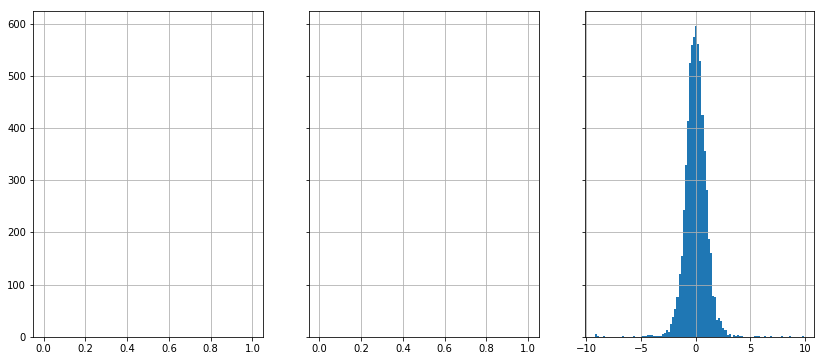

In [41]:
# plot zscores for loneliness
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
# These means are comparable as standardised using 2016 mean and std.
data[data['Year'] == 2016]['loneliness_zscore'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneliness_zscore'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneliness_zscore'].hist(bins=100, ax = ax3);

In [42]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcodes_GPs_stats.csv")

# Create Loneliness Variable

The actual loneliness variable we work with is the sum of the standardised scores of: depression, alzheimers, hypertension, insomnia, addiction and social anxiety, for each year of interest.

This means that the loneliness variable is actually an equally weighted index of the above domains.

In [43]:
# sum function ignores NAs
data['loneills'] =  data[['depression_zscore', 'alzheimers_zscore', 'hypertension_zscore', 'insomnia_zscore',
                          'addiction_zscore','social anxiety_zscore']].sum(axis=1)

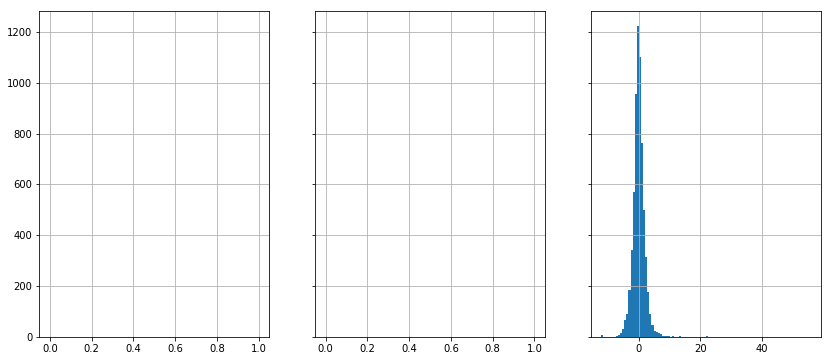

In [44]:
# plot zscores for loneills
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = (14,6), sharey = True)

# Note that there appears to be increasing variation in lonelines prescribing over time.
data[data['Year'] == 2016]['loneills'].hist(bins=100, ax = ax1)
data[data['Year'] == 2017]['loneills'].hist(bins=100, ax = ax2)
data[data['Year'] == 2018]['loneills'].hist(bins=100, ax = ax3);

In [45]:
# Save aggregated data
data.to_csv(path + "final_data.csv")